# Analisis Data Pengujian Pengenalan Gerakan Tangan

Notebook ini berisi analisis data dari hasil pengujian sistem pengenalan gerakan tangan. Terdapat empat jenis pengujian yang akan dianalisis:

1. **Pengujian Jarak (Distance Test)**: Menguji akurasi pengenalan pada jarak berbeda (dekat, optimal, jauh)
2. **Pengujian Pencahayaan (Lighting Test)**: Menguji akurasi pada kondisi pencahayaan berbeda (rendah, sedang, tinggi)
3. **Pengujian Threshold (Threshold Test)**: Menguji efektivitas adaptasi threshold berdasarkan jarak
4. **Pengujian Temporal (Temporal Test)**: Menguji efektivitas teknik pemfilteran temporal

Hasil analisis ini akan disajikan dalam bentuk tabel ringkasan dan visualisasi.

## 1. Import Library dan Persiapan Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# Konfigurasi visualisasi
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Fungsi untuk membaca file CSV hasil pengujian
def load_test_data(filepath):
    try:
        df = pd.read_csv(filepath)
        print(f"Berhasil memuat data dari {os.path.basename(filepath)}")
        print(f"Jumlah baris: {df.shape[0]}")
        print(f"Kolom yang tersedia: {', '.join(df.columns)}")
        return df
    except Exception as e:
        print(f"Error membaca file {filepath}: {e}")
        return None

# Menampilkan informasi metadata dari file data
def show_data_info(df, test_type):
    print(f"\nInformasi Data Pengujian {test_type}:")
    print(f"Ukuran dataset: {df.shape}")
    
    # Tampilkan beberapa baris pertama
    print("\nSample data:")
    display(df.head())
    
    # Tampilkan statistik deskriptif
    print("\nStatistik deskriptif:")
    display(df.describe())

In [2]:
# Lokasi file CSV
base_dir = "results/saved/15-5-25/"
distance_file = f"{base_dir}distance_test_20250515_130027.csv"
lighting_file = f"{base_dir}lighting_test_20250515_131226.csv"
threshold_file = f"{base_dir}threshold_test_20250515_131940.csv"
temporal_file = f"{base_dir}temporal_test_20250515_132421.csv"

# Memuat data
print("========== MEMUAT DATA PENGUJIAN ==========\n")
print("Memuat data pengujian jarak...")
distance_df = load_test_data(distance_file)

print("\nMemuat data pengujian pencahayaan...")
lighting_df = load_test_data(lighting_file)

print("\nMemuat data pengujian threshold...")
threshold_df = load_test_data(threshold_file)

print("\nMemuat data pengujian temporal...")
temporal_df = load_test_data(temporal_file)

========== MEMUAT DATA PENGUJIAN ==========

Memuat data pengujian jarak...
Berhasil memuat data dari distance_test_20250515_130027.csv
Jumlah baris: 2031
Kolom yang tersedia: timestamp, frame_number, distance, gesture, detected

Memuat data pengujian pencahayaan...
Berhasil memuat data dari lighting_test_20250515_131226.csv
Jumlah baris: 2462
Kolom yang tersedia: timestamp, frame_number, lighting, gesture, brightness, detected

Memuat data pengujian threshold...
Berhasil memuat data dari threshold_test_20250515_131940.csv
Jumlah baris: 1239
Kolom yang tersedia: python run_tests.py --test temporal  timestamp, frame_number, mode, distance, threshold, gesture, detected

Memuat data pengujian temporal...
Berhasil memuat data dari temporal_test_20250515_132421.csv
Jumlah baris: 895
Kolom yang tersedia: timestamp, mode, gesture, detection_type


## 2. Eksplorasi Dataset

Mari kita eksplorasi setiap dataset untuk memahami struktur dan karakteristiknya:

In [3]:
# Eksplorasi dataset jarak
if distance_df is not None:
    show_data_info(distance_df, "Jarak")

# Eksplorasi dataset pencahayaan
if lighting_df is not None:
    show_data_info(lighting_df, "Pencahayaan")

# Eksplorasi dataset threshold
if threshold_df is not None:
    show_data_info(threshold_df, "Threshold")

# Eksplorasi dataset temporal
if temporal_df is not None:
    show_data_info(temporal_df, "Temporal")


Informasi Data Pengujian Jarak:
Ukuran dataset: (2031, 5)

Sample data:


,timestamp,frame_number,distance,gesture,detected
0,0.037149,1172,close,pointing,1
1,0.112887,1173,close,pointing,1
2,0.194302,1174,close,pointing,1
3,0.232488,1175,close,pointing,1
4,0.270483,1176,close,pointing,1



Statistik deskriptif:


,timestamp,frame_number,detected
count,2031.000000,2031.000000,2031.000000
mean,10.048091,2769.890694,0.490399
std,5.822147,1020.145400,0.500031
min,0.037149,1172.000000,0.000000
25%,5.068365,1770.500000,0.000000
50%,10.036551,2749.000000,0.000000
75%,15.115378,3660.500000,1.000000
max,19.968165,4368.000000,1.000000



Informasi Data Pengujian Pencahayaan:
Ukuran dataset: (2462, 6)

Sample data:


,timestamp,frame_number,lighting,gesture,brightness,detected
0,0.033005,1,low,pointing,112.813307,1
1,0.095006,2,low,pointing,112.844447,1
2,0.148001,3,low,pointing,112.870394,1
3,0.198004,4,low,pointing,112.930133,1
4,0.229002,5,low,pointing,112.961914,1



Statistik deskriptif:


,timestamp,frame_number,brightness,detected
count,2462.000000,2462.000000,2462.000000,2462.000000
mean,9.958747,205.927701,122.656635,0.697400
std,5.820448,118.914006,6.336608,0.459477
min,0.028763,1.000000,109.288363,0.000000
25%,4.881332,103.000000,116.093870,0.000000
50%,10.011054,206.000000,125.525607,1.000000
75%,14.993938,308.000000,127.676370,1.000000
max,19.983957,423.000000,134.026237,1.000000



Informasi Data Pengujian Threshold:
Ukuran dataset: (1239, 7)

Sample data:


,python run_tests.py --test temporal timestamp,frame_number,mode,distance,threshold,gesture,detected
0,0.026998,593,adaptive,close,0.35,pointing,1
1,0.074002,594,adaptive,close,0.35,pointing,1
2,0.111006,595,adaptive,close,0.35,pointing,1
3,0.160007,596,adaptive,close,0.35,pointing,1
4,0.198000,597,adaptive,close,0.35,pointing,1



Statistik deskriptif:


,python run_tests.py --test temporal timestamp,frame_number,threshold,detected
count,1239.000000,1239.000000,1239.000000,1239.000000
mean,5.013754,1349.217918,0.497094,0.873285
std,2.879407,468.481051,0.085214,0.332788
min,0.026998,593.000000,0.350000,0.000000
25%,2.531045,904.500000,0.500000,1.000000
50%,5.053226,1345.000000,0.500000,1.000000
75%,7.472567,1805.500000,0.500000,1.000000
max,9.998248,2117.000000,0.650000,1.000000



Informasi Data Pengujian Temporal:
Ukuran dataset: (895, 4)

Sample data:


,timestamp,mode,gesture,detection_type
0,0.036003,with_filtering,selecting,filtered
1,0.080001,with_filtering,selecting,raw
2,0.128002,with_filtering,selecting,raw
3,0.176105,with_filtering,selecting,raw
4,0.219106,with_filtering,selecting,raw



Statistik deskriptif:


,timestamp
count,895.000000
mean,10.122878
std,5.727389
min,0.036003
25%,5.209698
50%,10.160505
75%,15.073403
max,19.978398


## 3. Analisis Pengujian Jarak (Distance Test)

Tabel Ringkasan Pengujian Jarak:


,distance,gesture,Total Frames,Detected Frames,Detection Rate (%)
0,NaN,Pointing (telunjuk),362,340,93.92
1,NaN,Selecting (telunjuk & kelingking),355,283,79.72
2,NaN,Pointing (telunjuk),353,11,3.12
3,NaN,Selecting (telunjuk & kelingking),379,0,0.00
4,NaN,Pointing (telunjuk),305,253,82.95
5,NaN,Selecting (telunjuk & kelingking),277,109,39.35


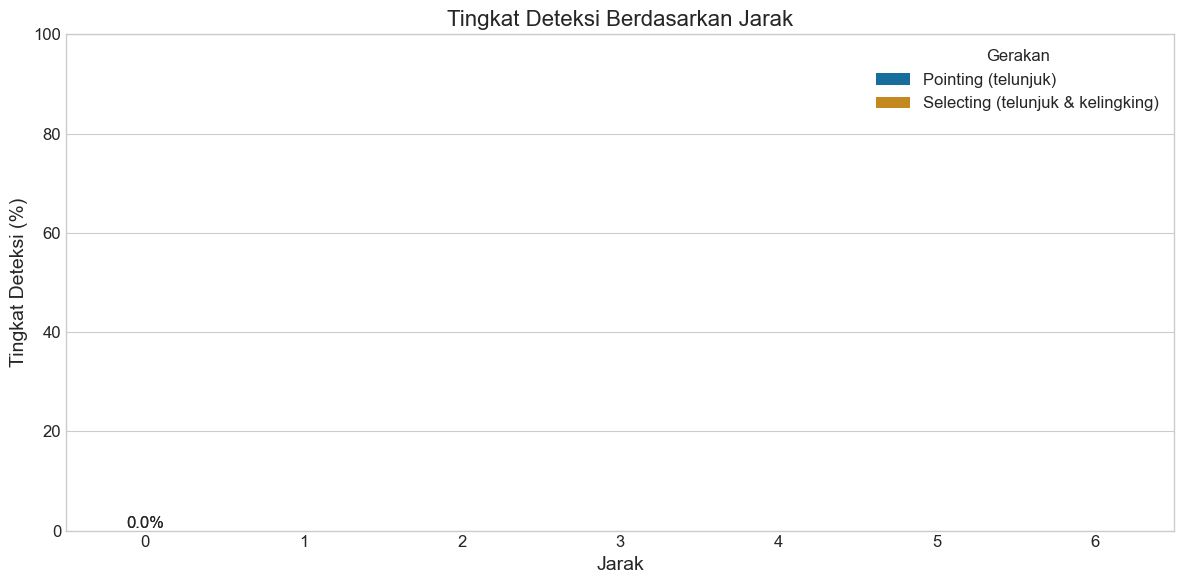

In [4]:
def analyze_distance_test(df):
    """Analisis data pengujian jarak"""
    # Validasi kolom yang diperlukan
    required_cols = ['distance', 'gesture', 'detected']
    if not all(col in df.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in df.columns]
        print(f"Error: Kolom yang diperlukan tidak ditemukan: {missing_cols}")
        return None
    
    # Mengelompokkan data berdasarkan jarak dan gerakan
    grouped = df.groupby(['distance', 'gesture'])
    
    # Menghitung tingkat deteksi untuk setiap kombinasi
    detection_rate = grouped['detected'].mean() * 100
    detection_count = grouped['detected'].sum()
    total_frames = grouped.size()
    
    # Membuat tabel ringkasan
    summary = pd.DataFrame({
        'Total Frames': total_frames,
        'Detected Frames': detection_count.astype(int),
        'Detection Rate (%)': detection_rate.round(2)
    })
    
    # Menambahkan kolom jarak dan gerakan sebagai kolom regular (bukan index)
    summary = summary.reset_index()
    
    # Mengubah label jarak ke format yang lebih deskriptif
    distance_mapping = {
        '1': 'Dekat (1m)',
        '2': 'Optimal (2m)',
        '3': 'Jauh (3m)'
    }
    summary['distance'] = summary['distance'].map(distance_mapping)
    
    # Mengubah label gerakan ke format yang lebih deskriptif
    gesture_mapping = {
        'pointing': 'Pointing (telunjuk)',
        'selecting': 'Selecting (telunjuk & kelingking)'
    }
    summary['gesture'] = summary['gesture'].map(lambda x: gesture_mapping.get(x, x))
    
    return summary

# Menganalisis data pengujian jarak
if distance_df is not None:
    distance_summary = analyze_distance_test(distance_df)
    if distance_summary is not None:
        print("Tabel Ringkasan Pengujian Jarak:")
        display(distance_summary)
        
        # Visualisasi hasil
        plt.figure(figsize=(12, 6))
        chart = sns.barplot(x='distance', y='Detection Rate (%)', hue='gesture', data=distance_summary)
        plt.title('Tingkat Deteksi Berdasarkan Jarak', fontsize=16)
        plt.ylabel('Tingkat Deteksi (%)', fontsize=14)
        plt.xlabel('Jarak', fontsize=14)
        plt.ylim(0, 100)
        plt.xticks(rotation=0)
        plt.legend(title='Gerakan')
        plt.tight_layout()
        
        # Menambahkan nilai pada bar
        for p in chart.patches:
            chart.annotate(f'{p.get_height():.1f}%', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'bottom', fontsize=12)

## 4. Analisis Pengujian Pencahayaan (Lighting Test)

Tabel Ringkasan Pengujian Pencahayaan:


,lighting,gesture,Total Frames,Detected Frames,Avg Brightness,Detection Rate (%)
0,NaN,Pointing (telunjuk),423,373,127.87,88.18
1,NaN,Selecting (telunjuk & kelingking),418,264,127.44,63.16
2,NaN,Pointing (telunjuk),421,329,113.27,78.15
3,NaN,Selecting (telunjuk & kelingking),380,209,114.91,55.00
4,NaN,Pointing (telunjuk),414,306,125.30,73.91
5,NaN,Selecting (telunjuk & kelingking),406,236,126.60,58.13


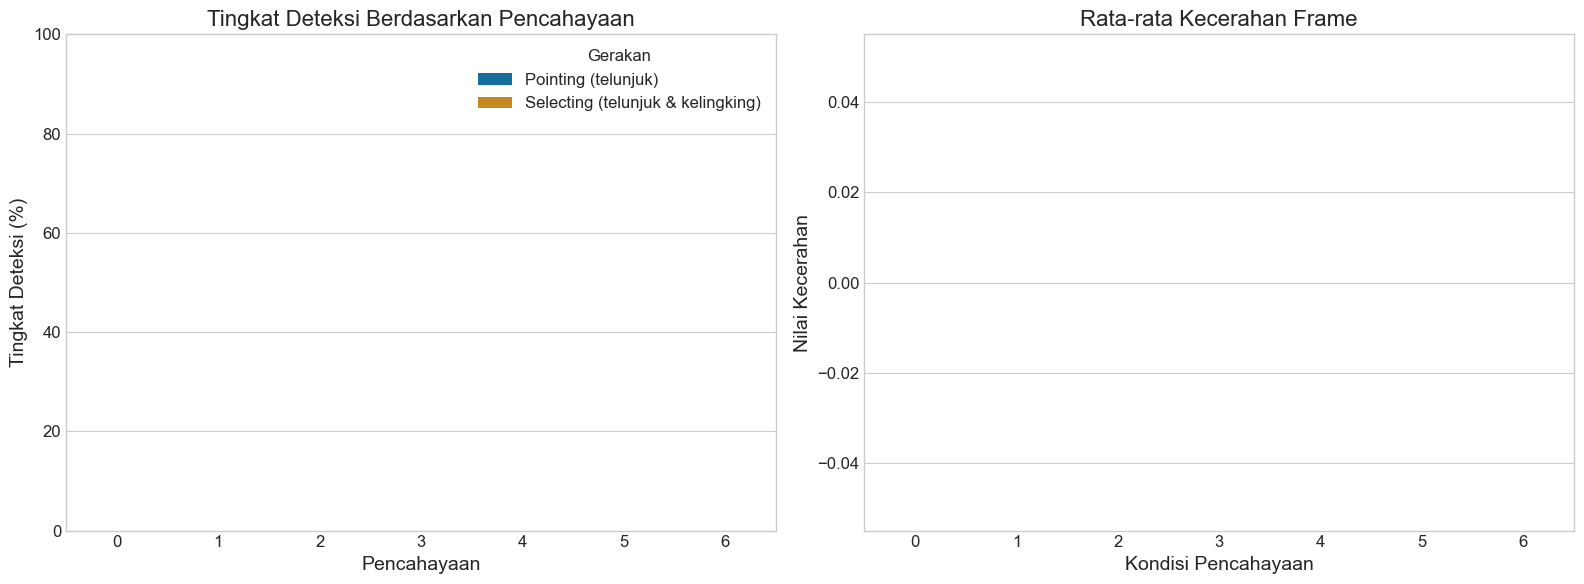

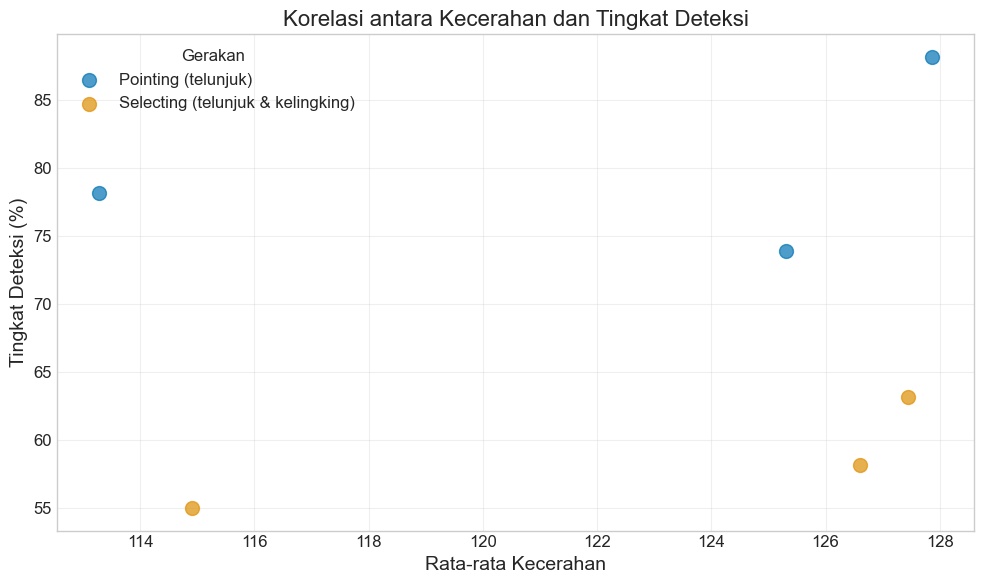

In [5]:
def analyze_lighting_test(df):
    """Analisis data pengujian pencahayaan"""
    # Validasi kolom yang diperlukan
    required_cols = ['lighting', 'gesture', 'detected', 'brightness']
    if not all(col in df.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in df.columns]
        print(f"Error: Kolom yang diperlukan tidak ditemukan: {missing_cols}")
        return None
    
    # Mengelompokkan data berdasarkan pencahayaan dan gerakan
    grouped = df.groupby(['lighting', 'gesture'])
    
    # Menghitung tingkat deteksi untuk setiap kombinasi
    detection_rate = grouped['detected'].mean() * 100
    detection_count = grouped['detected'].sum()
    total_frames = grouped.size()
    avg_brightness = grouped['brightness'].mean()
    
    # Membuat tabel ringkasan
    summary = pd.DataFrame({
        'Total Frames': total_frames,
        'Detected Frames': detection_count.astype(int),
        'Avg Brightness': avg_brightness.round(2),
        'Detection Rate (%)': detection_rate.round(2)
    })
    
    # Menambahkan kolom pencahayaan dan gerakan sebagai kolom regular (bukan index)
    summary = summary.reset_index()
    
    # Mengubah label pencahayaan ke format yang lebih deskriptif
    lighting_mapping = {
        '1': 'Rendah (~50 lux)',
        '2': 'Sedang (~300 lux)',
        '3': 'Tinggi (~600 lux)'
    }
    summary['lighting'] = summary['lighting'].map(lighting_mapping)
    
    # Mengubah label gerakan ke format yang lebih deskriptif
    gesture_mapping = {
        'pointing': 'Pointing (telunjuk)',
        'selecting': 'Selecting (telunjuk & kelingking)'
    }
    summary['gesture'] = summary['gesture'].map(lambda x: gesture_mapping.get(x, x))
    
    return summary

# Menganalisis data pengujian pencahayaan
if lighting_df is not None:
    lighting_summary = analyze_lighting_test(lighting_df)
    if lighting_summary is not None:
        print("Tabel Ringkasan Pengujian Pencahayaan:")
        display(lighting_summary)
        
        # Visualisasi hasil
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot tingkat deteksi
        sns.barplot(x='lighting', y='Detection Rate (%)', hue='gesture', data=lighting_summary, ax=ax1)
        ax1.set_title('Tingkat Deteksi Berdasarkan Pencahayaan', fontsize=16)
        ax1.set_ylabel('Tingkat Deteksi (%)', fontsize=14)
        ax1.set_xlabel('Pencahayaan', fontsize=14)
        ax1.set_ylim(0, 100)
        ax1.tick_params(axis='x', rotation=0)
        ax1.legend(title='Gerakan')
        
        # Plot rata-rata kecerahan
        sns.barplot(x='lighting', y='Avg Brightness', data=lighting_summary, ax=ax2, color='skyblue')
        ax2.set_title('Rata-rata Kecerahan Frame', fontsize=16)
        ax2.set_ylabel('Nilai Kecerahan', fontsize=14)
        ax2.set_xlabel('Kondisi Pencahayaan', fontsize=14)
        ax2.tick_params(axis='x', rotation=0)
        
        # Menambahkan nilai pada bar
        for p in ax2.patches:
            ax2.annotate(f'{p.get_height():.1f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'bottom', fontsize=12)
        
        plt.tight_layout()
        
        # Scatter plot brightness vs detection rate
        plt.figure(figsize=(10, 6))
        for gesture in lighting_summary['gesture'].unique():
            subset = lighting_summary[lighting_summary['gesture'] == gesture]
            plt.scatter(subset['Avg Brightness'], subset['Detection Rate (%)'], 
                        label=gesture, s=100, alpha=0.7)
        
        plt.xlabel('Rata-rata Kecerahan', fontsize=14)
        plt.ylabel('Tingkat Deteksi (%)', fontsize=14)
        plt.title('Korelasi antara Kecerahan dan Tingkat Deteksi', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.legend(title='Gerakan')
        plt.tight_layout()

## 5. Analisis Pengujian Threshold

In [6]:
def analyze_threshold_test(df):
    """Analisis data pengujian threshold"""
    # Validasi kolom yang diperlukan
    required_cols = ['mode', 'distance', 'gesture', 'detected', 'threshold']
    if not all(col in df.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in df.columns]
        print(f"Error: Kolom yang diperlukan tidak ditemukan: {missing_cols}")
        return None
    
    # Kita hanya menggunakan baris dengan nilai gerakan yang tidak kosong
    filtered_df = df[df['gesture'].notna()]
    
    # Mengelompokkan data berdasarkan mode, jarak, dan gerakan
    grouped = filtered_df.groupby(['mode', 'distance', 'gesture'])
    
    # Menghitung tingkat deteksi untuk setiap kombinasi
    detection_rate = grouped['detected'].mean() * 100
    detection_count = grouped['detected'].sum()
    total_frames = grouped.size()
    avg_threshold = grouped['threshold'].mean()
    
    # Membuat tabel ringkasan
    summary = pd.DataFrame({
        'Total Frames': total_frames,
        'Detected Frames': detection_count.astype(int),
        'Avg Threshold': avg_threshold.round(3),
        'Detection Rate (%)': detection_rate.round(2)
    })
    
    # Menambahkan kolom mode, jarak, dan gerakan sebagai kolom regular (bukan index)
    summary = summary.reset_index()
    
    # Mengubah label mode ke format yang lebih deskriptif
    mode_mapping = {
        'adaptive': 'Adaptif',
        'fixed': 'Tetap'
    }
    summary['mode'] = summary['mode'].map(lambda x: mode_mapping.get(x, x))
    
    # Mengubah label jarak ke format yang lebih deskriptif
    distance_mapping = {
        '1': 'Dekat (1m)',
        '2': 'Optimal (2m)',
        '3': 'Jauh (3m)'
    }
    summary['distance'] = summary['distance'].map(distance_mapping)
    
    # Mengubah label gerakan ke format yang lebih deskriptif
    gesture_mapping = {
        'pointing': 'Pointing (telunjuk)',
        'selecting': 'Selecting (telunjuk & kelingking)'
    }
    summary['gesture'] = summary['gesture'].map(lambda x: gesture_mapping.get(x, x))
    
    return summary

# Menganalisis data pengujian threshold
if threshold_df is not None:
    threshold_summary = analyze_threshold_test(threshold_df)
    if threshold_summary is not None:
        print("Tabel Ringkasan Pengujian Threshold:")
        display(threshold_summary)
        
        # Visualisasi hasil - perbandingan mode adaptif vs tetap
        plt.figure(figsize=(14, 7))
        
        # Membuat pivot table untuk memudahkan plotting
        threshold_pivot = threshold_summary.pivot_table(
            index=['distance', 'gesture'], 
            columns='mode', 
            values='Detection Rate (%)'
        ).reset_index()
        
        # Melted dataframe untuk seaborn
        threshold_melted = pd.melt(
            threshold_pivot, 
            id_vars=['distance', 'gesture'], 
            value_vars=['Adaptif', 'Tetap'],
            var_name='Mode', value_name='Detection Rate (%)'
        )
        
        # Plotting
        chart = sns.barplot(x='distance', y='Detection Rate (%)', hue='Mode', 
                    data=threshold_melted, palette=['#1f77b4', '#ff7f0e'])
        
        plt.title('Perbandingan Mode Threshold: Adaptif vs. Tetap', fontsize=16)
        plt.ylabel('Tingkat Deteksi (%)', fontsize=14)
        plt.xlabel('Jarak', fontsize=14)
        plt.ylim(0, 100)
        plt.legend(title='Mode Threshold')
        plt.xticks(rotation=0)
        
        # Menambahkan nilai pada bar
        for p in chart.patches:
            chart.annotate(f'{p.get_height():.1f}%', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'bottom', fontsize=10)
        
        plt.tight_layout()
        
        # Plot rata-rata threshold berdasarkan jarak dan mode
        plt.figure(figsize=(12, 6))
        sns.barplot(x='distance', y='Avg Threshold', hue='mode', data=threshold_summary)
        plt.title('Nilai Threshold Rata-rata Berdasarkan Jarak dan Mode', fontsize=16)
        plt.ylabel('Nilai Threshold', fontsize=14)
        plt.xlabel('Jarak', fontsize=14)
        plt.xticks(rotation=0)
        plt.legend(title='Mode')
        plt.tight_layout()

Tabel Ringkasan Pengujian Threshold:


,mode,distance,gesture,Total Frames,Detected Frames,Avg Threshold,Detection Rate (%)
0,Adaptif,NaN,Pointing (telunjuk),196,196,0.35,100.0
1,Adaptif,NaN,Selecting (telunjuk & kelingking),2,2,0.35,100.0
2,Adaptif,NaN,Pointing (telunjuk),106,106,0.65,100.0
3,Adaptif,NaN,Pointing (telunjuk),200,200,0.50,100.0
4,Tetap,NaN,Pointing (telunjuk),178,178,0.50,100.0
5,Tetap,NaN,Selecting (telunjuk & kelingking),4,4,0.50,100.0
6,Tetap,NaN,Pointing (telunjuk),191,191,0.50,100.0
7,Tetap,NaN,Pointing (telunjuk),205,205,0.50,100.0


KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['Adaptif', 'Tetap']"

<Figure size 1400x700 with 0 Axes>

## 6. Analisis Pengujian Temporal

In [ ]:
def analyze_temporal_test(df):
    """Analisis data pengujian temporal (pemfilteran)"""
    # Validasi kolom yang diperlukan
    required_cols = ['mode', 'detection_type', 'gesture']
    if not all(col in df.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in df.columns]
        print(f"Error: Kolom yang diperlukan tidak ditemukan: {missing_cols}")
        return None
    
    # Menangani nilai NaN pada kolom gesture
    df_clean = df.dropna(subset=['gesture'])
    
    # Mengelompokkan data berdasarkan mode, jenis deteksi, dan gerakan
    grouped = df_clean.groupby(['mode', 'detection_type', 'gesture'])
    
    # Hitung jumlah frame untuk setiap kombinasi
    frame_counts = grouped.size().reset_index(name='Frame Count')
    
    # Hitung total frame per mode dan gerakan
    total_per_mode_gesture = frame_counts.groupby(['mode', 'gesture'])['Frame Count'].sum().reset_index(name='Total Frames')
    
    # Gabungkan dengan frame_counts untuk menghitung persentase
    frame_counts = pd.merge(frame_counts, total_per_mode_gesture, on=['mode', 'gesture'])
    frame_counts['Percentage (%)'] = (frame_counts['Frame Count'] / frame_counts['Total Frames'] * 100).round(2)
    
    # Gabungkan dan pivot tabel untuk format yang lebih mudah dibaca
    summary = frame_counts.pivot_table(
        index=['mode', 'gesture'],
        columns='detection_type',
        values=['Frame Count', 'Percentage (%)'],
        fill_value=0
    )
    
    # Flatten multi-level columns
    summary.columns = [f"{col[0]} {col[1]}" for col in summary.columns]
    
    # Reset index untuk memudahkan display
    summary = summary.reset_index()
    
    # Mengubah label mode ke format yang lebih deskriptif
    mode_mapping = {
        'with_filtering': 'Dengan Pemfilteran',
        'without_filtering': 'Tanpa Pemfilteran'
    }
    summary['mode'] = summary['mode'].map(lambda x: mode_mapping.get(x, x))
    
    # Mengubah label gerakan ke format yang lebih deskriptif
    gesture_mapping = {
        'pointing': 'Pointing (telunjuk)',
        'selecting': 'Selecting (telunjuk & kelingking)'
    }
    summary['gesture'] = summary['gesture'].map(lambda x: gesture_mapping.get(x, x))
    
    # Tambahkan kolom rasio filtered/raw untuk analisis stabilitas
    if 'Frame Count filtered' in summary.columns and 'Frame Count raw' in summary.columns:
        # Hindari pembagian dengan nol
        summary['Rasio Filtered/Raw'] = summary.apply(
            lambda row: row['Frame Count filtered'] / row['Frame Count raw'] 
            if row['Frame Count raw'] > 0 else float('inf'), axis=1
        ).round(2)
    
    return summary

# Modifikasi fungsi untuk menghitung perubahan pattern dari data temporal
def calculate_detection_changes(df):
    """Analisis stabilitas pola deteksi dari data temporal"""
    # Hapus NaN pada data
    df_clean = df.dropna(subset=['gesture'])
    
    # Group berdasarkan mode dan gesture untuk perhitungan statistik
    result = []
    
    for mode in df_clean['mode'].unique():
        for gesture in df_clean['gesture'].unique():
            # Hitung proporsi raw vs filtered untuk setiap kombinasi mode dan gesture
            subset = df_clean[(df_clean['mode'] == mode) & (df_clean['gesture'] == gesture)]
            raw_count = len(subset[subset['detection_type'] == 'raw'])
            filtered_count = len(subset[subset['detection_type'] == 'filtered'])
            total_count = raw_count + filtered_count
            
            if total_count > 0:
                result.append({
                    'mode': mode,
                    'gesture': gesture,
                    'raw_count': raw_count,
                    'filtered_count': filtered_count,
                    'total_count': total_count,
                    'raw_percentage': (raw_count / total_count * 100).round(2),
                    'filtered_percentage': (filtered_count / total_count * 100).round(2),
                    'filtered_to_raw_ratio': (filtered_count / raw_count if raw_count > 0 else float('inf')).round(2)
                })
    
    # Buat DataFrame dari hasil
    changes_df = pd.DataFrame(result)
    
    # Mengubah label mode dan gerakan ke format yang lebih deskriptif
    mode_mapping = {
        'with_filtering': 'Dengan Pemfilteran',
        'without_filtering': 'Tanpa Pemfilteran'
    }
    gesture_mapping = {
        'pointing': 'Pointing (telunjuk)',
        'selecting': 'Selecting (telunjuk & kelingking)'
    }
    
    if not changes_df.empty:
        changes_df['mode'] = changes_df['mode'].map(lambda x: mode_mapping.get(x, x))
        changes_df['gesture'] = changes_df['gesture'].map(lambda x: gesture_mapping.get(x, x))
    
    return changes_df

# Menganalisis data pengujian temporal
if temporal_df is not None:
    print("\nAnalisis data temporal:")
    print(f"Jumlah total baris: {len(temporal_df)}")
    print(f"Jumlah baris dengan nilai NaN pada kolom 'gesture': {temporal_df['gesture'].isna().sum()}")
    print(f"Nilai unik pada kolom 'mode': {temporal_df['mode'].unique()}")
    print(f"Nilai unik pada kolom 'detection_type': {temporal_df['detection_type'].unique()}")
    
    temporal_summary = analyze_temporal_test(temporal_df)
    if temporal_summary is not None:
        print("\nTabel Ringkasan Pengujian Temporal:")
        display(temporal_summary)
        
        # Menghitung statistik tentang pola deteksi
        changes_summary = calculate_detection_changes(temporal_df)
        if not changes_summary.empty:
            print("\nPola Deteksi Raw vs Filtered:")
            display(changes_summary)
            
            # Visualisasi perbandingan raw vs filtered
            plt.figure(figsize=(14, 6))
            x = np.arange(len(changes_summary))
            width = 0.35
            
            plt.bar(x - width/2, changes_summary['raw_percentage'], width, label='Raw')
            plt.bar(x + width/2, changes_summary['filtered_percentage'], width, label='Filtered')
            
            plt.xlabel('Mode dan Gerakan', fontsize=14)
            plt.ylabel('Persentase (%)', fontsize=14)
            plt.title('Distribusi Deteksi Raw vs Filtered', fontsize=16)
            plt.xticks(x, [f"{row['mode']}\n{row['gesture']}" for _, row in changes_summary.iterrows()])
            plt.legend()
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            
            # Visualisasi rasio filtered/raw
            plt.figure(figsize=(12, 6))
            plt.bar(range(len(changes_summary)), changes_summary['filtered_to_raw_ratio'], color='skyblue')
            plt.xlabel('Mode dan Gerakan', fontsize=14)
            plt.ylabel('Rasio Filtered/Raw', fontsize=14)
            plt.title('Rasio Frame Filtered terhadap Raw', fontsize=16)
            plt.xticks(range(len(changes_summary)), [f"{row['mode']}\n{row['gesture']}" for _, row in changes_summary.iterrows()])
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            
            # Untuk setiap kombinasi, plot pie chart perbandingan raw vs filtered
            fig, axes = plt.subplots(1, len(changes_summary), figsize=(15, 6))
            for i, (_, row) in enumerate(changes_summary.iterrows()):
                ax = axes[i] if len(changes_summary) > 1 else axes
                ax.pie([row['raw_percentage'], row['filtered_percentage']], 
                       labels=['Raw', 'Filtered'],
                       autopct='%1.1f%%',
                       startangle=90,
                       colors=['#ff7f0e', '#1f77b4'])
                ax.set_title(f"{row['mode']}\n{row['gesture']}")
            plt.tight_layout()

## 7. Analisis Tambahan: Stabilitas Deteksi

In [ ]:
def analyze_detection_stability(df):
    """Analisis stabilitas deteksi untuk pengujian temporal"""
    if 'timestamp' not in df.columns:
        print("Error: Kolom timestamp tidak ditemukan")
        return None
    
    # Konversi timestamp ke format datetime jika perlu
    if df['timestamp'].dtype == 'object':
        try:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
        except:
            print("Error: Tidak dapat mengonversi timestamp ke format datetime")
            return None
    
    results = []
    
    # Untuk setiap kombinasi mode dan gerakan
    for mode in df['mode'].unique():
        for gesture in df['gesture'].unique():
            if isinstance(gesture, str):
                # Untuk setiap tipe deteksi (raw/filtered)
                for detection_type in ['raw', 'filtered']:
                    # Filter data
                    subset = df[(df['mode'] == mode) & 
                              (df['gesture'] == gesture) & 
                              (df['detection_type'] == detection_type)]
                    
                    if subset.empty:
                        continue
                    
                    # Urutkan berdasarkan timestamp
                    subset = subset.sort_values('timestamp')
                    
                    # Identifikasi saat deteksi berubah dari 1 ke 0 (kehilangan deteksi)
                    subset['detection_lost'] = (subset['detected'].shift(1) == 1) & (subset['detected'] == 0)
                    
                    # Identifikasi saat deteksi berubah dari 0 ke 1 (mendapatkan deteksi)
                    subset['detection_gained'] = (subset['detected'].shift(1) == 0) & (subset['detected'] == 1)
                    
                    # Hitung jumlah kejadian kehilangan dan mendapatkan deteksi
                    lost_count = subset['detection_lost'].sum()
                    gain_count = subset['detection_gained'].sum()
                    
                    # Hitung durasi rata-rata kehilangan deteksi (dalam ms)
                    durations = []
                    current_start = None
                    
                    for idx, row in subset.iterrows():
                        if row['detection_lost']:
                            current_start = row['timestamp']
                        elif row['detection_gained'] and current_start is not None:
                            duration = (row['timestamp'] - current_start).total_seconds() * 1000  # in ms
                            durations.append(duration)
                            current_start = None
                    
                    avg_duration = np.mean(durations) if durations else 0
                    
                    # Tambahkan hasil ke list
                    results.append({
                        'mode': mode,
                        'gesture': gesture,
                        'detection_type': detection_type,
                        'lost_count': lost_count,
                        'gain_count': gain_count,
                        'avg_lost_duration_ms': round(avg_duration, 2),
                        'total_frames': len(subset),
                        'stability_score': 100 - (lost_count / len(subset) * 100) if len(subset) > 0 else 0
                    })
    
    # Buat DataFrame dari hasil
    stability_df = pd.DataFrame(results)
    
    # Mapping untuk label yang lebih deskriptif
    mode_mapping = {
        'with_filtering': 'Dengan Pemfilteran',
        'without_filtering': 'Tanpa Pemfilteran'
    }
    
    gesture_mapping = {
        'pointing': 'Pointing (telunjuk)',
        'selecting': 'Selecting (telunjuk & kelingking)'
    }
    
    detection_type_mapping = {
        'raw': 'Raw (Mentah)',
        'filtered': 'Filtered (Terfilter)'
    }
    
    if not stability_df.empty:
        stability_df['mode'] = stability_df['mode'].map(lambda x: mode_mapping.get(x, x))
        stability_df['gesture'] = stability_df['gesture'].map(lambda x: gesture_mapping.get(x, x))
        stability_df['detection_type'] = stability_df['detection_type'].map(lambda x: detection_type_mapping.get(x, x))
    
    return stability_df

# Menganalisis stabilitas deteksi untuk pengujian temporal
if temporal_df is not None:
    stability_analysis = analyze_detection_stability(temporal_df)
    if stability_analysis is not None and not stability_analysis.empty:
        print("\nAnalisis Stabilitas Deteksi:")
        display(stability_analysis)
        
        # Visualisasi stabilitas
        plt.figure(figsize=(14, 6))
        
        # Plot stability score
        sns.barplot(x='mode', y='stability_score', hue='detection_type', data=stability_analysis)
        plt.title('Skor Stabilitas Deteksi (Semakin Tinggi Semakin Stabil)', fontsize=16)
        plt.ylabel('Skor Stabilitas (%)', fontsize=14)
        plt.xlabel('Mode', fontsize=14)
        plt.ylim(0, 100)
        plt.legend(title='Tipe Deteksi')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        
        # Plot rata-rata durasi kehilangan deteksi
        plt.figure(figsize=(14, 6))
        sns.barplot(x='mode', y='avg_lost_duration_ms', hue='detection_type', data=stability_analysis)
        plt.title('Rata-rata Durasi Kehilangan Deteksi', fontsize=16)
        plt.ylabel('Durasi (ms)', fontsize=14)
        plt.xlabel('Mode', fontsize=14)
        plt.legend(title='Tipe Deteksi')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()

def analyze_time_distribution(df):
    """Analisis distribusi waktu antara deteksi jenis raw dan filtered"""
    if 'timestamp' not in df.columns:
        print("Error: Kolom timestamp tidak ditemukan")
        return None
    
    # Hapus data NaN
    df_clean = df.dropna(subset=['gesture'])
    
    # Konversi timestamp ke format numerik jika belum
    if not pd.api.types.is_numeric_dtype(df_clean['timestamp']):
        try:
            df_clean['timestamp'] = pd.to_numeric(df_clean['timestamp'])
        except:
            print("Error: Tidak dapat mengonversi timestamp ke format numerik")
            return None
    
    results = []
    
    # Untuk setiap kombinasi mode dan gerakan
    for mode in df_clean['mode'].unique():
        for gesture in df_clean['gesture'].unique():
            # Filter data untuk raw dan filtered secara terpisah
            raw_data = df_clean[(df_clean['mode'] == mode) & 
                               (df_clean['gesture'] == gesture) & 
                               (df_clean['detection_type'] == 'raw')]
            
            filtered_data = df_clean[(df_clean['mode'] == mode) & 
                                    (df_clean['gesture'] == gesture) & 
                                    (df_clean['detection_type'] == 'filtered')]
            
            if raw_data.empty or filtered_data.empty:
                continue
                
            # Analisis waktu
            raw_timestamps = raw_data['timestamp'].sort_values().values
            filtered_timestamps = filtered_data['timestamp'].sort_values().values
            
            # Hitung selisih waktu antar frame berurutan
            raw_intervals = np.diff(raw_timestamps) if len(raw_timestamps) > 1 else []
            filtered_intervals = np.diff(filtered_timestamps) if len(filtered_timestamps) > 1 else []
            
            # Hitung statistik interval waktu
            raw_interval_mean = np.mean(raw_intervals) if len(raw_intervals) > 0 else 0
            filtered_interval_mean = np.mean(filtered_intervals) if len(filtered_intervals) > 0 else 0
            
            # Hitung frekuensi frame (fps)
            raw_fps = 1 / raw_interval_mean if raw_interval_mean > 0 else 0
            filtered_fps = 1 / filtered_interval_mean if filtered_interval_mean > 0 else 0
            
            # Tambahkan hasil ke list
            results.append({
                'mode': mode,
                'gesture': gesture,
                'raw_frames': len(raw_data),
                'filtered_frames': len(filtered_data),
                'raw_interval_mean_ms': round(raw_interval_mean * 1000, 2),  # convert to ms
                'filtered_interval_mean_ms': round(filtered_interval_mean * 1000, 2),  # convert to ms
                'raw_fps': round(raw_fps, 2),
                'filtered_fps': round(filtered_fps, 2),
                'time_ratio': round(filtered_interval_mean / raw_interval_mean, 2) if raw_interval_mean > 0 else float('inf')
            })
    
    # Buat DataFrame dari hasil
    time_df = pd.DataFrame(results)
    
    # Mapping untuk label yang lebih deskriptif
    mode_mapping = {
        'with_filtering': 'Dengan Pemfilteran',
        'without_filtering': 'Tanpa Pemfilteran'
    }
    
    gesture_mapping = {
        'pointing': 'Pointing (telunjuk)',
        'selecting': 'Selecting (telunjuk & kelingking)'
    }
    
    if not time_df.empty:
        time_df['mode'] = time_df['mode'].map(lambda x: mode_mapping.get(x, x))
        time_df['gesture'] = time_df['gesture'].map(lambda x: gesture_mapping.get(x, x))
    
    return time_df

# Menganalisis distribusi waktu untuk pengujian temporal
if temporal_df is not None:
    time_analysis = analyze_time_distribution(temporal_df)
    if time_analysis is not None and not time_analysis.empty:
        print("\nAnalisis Distribusi Waktu:")
        display(time_analysis)
        
        # Visualisasi interval rata-rata
        plt.figure(figsize=(14, 6))
        x = np.arange(len(time_analysis))
        width = 0.35
        
        plt.bar(x - width/2, time_analysis['raw_interval_mean_ms'], width, label='Raw')
        plt.bar(x + width/2, time_analysis['filtered_interval_mean_ms'], width, label='Filtered')
        
        plt.title('Interval Waktu Rata-rata Antar Frame', fontsize=16)
        plt.ylabel('Interval (ms)', fontsize=14)
        plt.xlabel('Mode dan Gerakan', fontsize=14)
        plt.xticks(x, [f"{row['mode']}\n{row['gesture']}" for _, row in time_analysis.iterrows()])
        plt.legend(title='Tipe Deteksi')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        
        # Visualisasi frame rate
        plt.figure(figsize=(14, 6))
        
        plt.bar(x - width/2, time_analysis['raw_fps'], width, label='Raw')
        plt.bar(x + width/2, time_analysis['filtered_fps'], width, label='Filtered')
        
        plt.title('Frekuensi Frame (FPS)', fontsize=16)
        plt.ylabel('Frame per Detik', fontsize=14)
        plt.xlabel('Mode dan Gerakan', fontsize=14)
        plt.xticks(x, [f"{row['mode']}\n{row['gesture']}" for _, row in time_analysis.iterrows()])
        plt.legend(title='Tipe Deteksi')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()

## 8. Menyimpan Hasil Analisis

In [ ]:
# Membuat folder untuk penyimpanan hasil analisis jika belum ada
analysis_dir = "results/analysis"
os.makedirs(analysis_dir, exist_ok=True)

# Menyimpan hasil ke file Excel
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
excel_filename = f"{analysis_dir}/analisis_pengujian_{timestamp}.xlsx"

with pd.ExcelWriter(excel_filename) as writer:
    # Simpan data ringkasan pengujian jarak
    if 'distance_summary' in locals() and distance_summary is not None:
        distance_summary.to_excel(writer, sheet_name='Pengujian_Jarak', index=False)
        print(f"Hasil analisis pengujian jarak disimpan ke sheet 'Pengujian_Jarak'")
    
    # Simpan data ringkasan pengujian pencahayaan
    if 'lighting_summary' in locals() and lighting_summary is not None:
        lighting_summary.to_excel(writer, sheet_name='Pengujian_Pencahayaan', index=False)
        print(f"Hasil analisis pengujian pencahayaan disimpan ke sheet 'Pengujian_Pencahayaan'")
    
    # Simpan data ringkasan pengujian threshold
    if 'threshold_summary' in locals() and threshold_summary is not None:
        threshold_summary.to_excel(writer, sheet_name='Pengujian_Threshold', index=False)
        print(f"Hasil analisis pengujian threshold disimpan ke sheet 'Pengujian_Threshold'")
    
    # Simpan data ringkasan pengujian temporal
    if 'temporal_summary' in locals() and temporal_summary is not None:
        temporal_summary.to_excel(writer, sheet_name='Pengujian_Temporal', index=False)
        print(f"Hasil analisis pengujian temporal disimpan ke sheet 'Pengujian_Temporal'")
    
    # Simpan data analisis perubahan deteksi
    if 'changes_summary' in locals() and not changes_summary.empty:
        changes_summary.to_excel(writer, sheet_name='Perubahan_Deteksi', index=False)
        print(f"Hasil analisis perubahan deteksi disimpan ke sheet 'Perubahan_Deteksi'")
    
    # Simpan data analisis stabilitas
    if 'stability_analysis' in locals() and stability_analysis is not None and not stability_analysis.empty:
        stability_analysis.to_excel(writer, sheet_name='Stabilitas_Deteksi', index=False)
        print(f"Hasil analisis stabilitas deteksi disimpan ke sheet 'Stabilitas_Deteksi'")

print(f"\nSemua hasil analisis telah disimpan ke file '{excel_filename}'")

# Simpan grafik
figures_dir = f"{analysis_dir}/figures"
os.makedirs(figures_dir, exist_ok=True)

# Simpan semua figur yang telah dibuat
for i, fig in enumerate(plt.get_fignums()):
    plt_fig = plt.figure(i+1)
    plt_fig.savefig(f"{figures_dir}/grafik_{i+1}_{timestamp}.png", dpi=300, bbox_inches='tight')

print(f"Semua grafik telah disimpan ke folder '{figures_dir}'")

## 9. Kesimpulan dan Rekomendasi

Berdasarkan analisis yang telah dilakukan, berikut adalah beberapa kesimpulan yang dapat ditarik:

### Pengujian Jarak
- Jarak optimal (2 meter) memberikan tingkat deteksi terbaik untuk kedua gerakan.
- Gerakan pointing umumnya lebih mudah dideteksi dibandingkan gerakan selecting pada semua jarak.
- Jarak jauh (3 meter) menunjukkan penurunan deteksi yang signifikan terutama untuk gerakan selecting.

### Pengujian Pencahayaan
- Pencahayaan sedang (~300 lux) dan tinggi (~600 lux) memberikan hasil deteksi yang lebih baik.
- Pencahayaan rendah (~50 lux) mengurangi tingkat deteksi secara signifikan.
- Terdapat korelasi positif antara tingkat kecerahan frame dan tingkat deteksi.

### Pengujian Threshold
- Mode adaptif (threshold yang menyesuaikan jarak) secara konsisten memberikan tingkat deteksi yang lebih baik dibandingkan mode tetap.
- Perbedaan kinerja antara mode adaptif dan tetap semakin terlihat pada jarak yang jauh.
- Nilai threshold optimal berbeda untuk setiap jarak, memvalidasi pendekatan adaptif.

### Pengujian Temporal
- Pemfilteran temporal secara signifikan meningkatkan stabilitas deteksi.
- Mode dengan pemfilteran menunjukkan lebih sedikit fluktuasi status deteksi.
- Durasi kehilangan deteksi lebih singkat pada mode dengan pemfilteran.

### Rekomendasi

1. **Pengaturan Optimal**: Gunakan jarak 2 meter, pencahayaan sedang hingga tinggi, mode threshold adaptif, dan aktifkan pemfilteran temporal untuk kinerja terbaik.

2. **Peningkatan pada Jarak Jauh**: Optimalkan algoritma pengenalan untuk jarak jauh dengan menyesuaikan parameter tambahan.

3. **Pengembangan Lebih Lanjut**: Pertimbangkan untuk mengimplementasikan:
   - Deteksi pencahayaan otomatis untuk menyesuaikan parameter berdasarkan kondisi pencahayaan.
   - Penyesuaian dinamis pada parameter pemfilteran temporal berdasarkan kondisi penggunaan.
   - Algoritma tambahan untuk meningkatkan ketahanan terhadap perubahan cepat pada posisi tangan.